Trial 3 Complete [00h 04m 07s]
val_loss: 97.76095581054688

Best val_loss So Far: 97.76095581054688
Total elapsed time: 00h 13m 00s
Epoch 1/500
73/73 [==============================] - 10s 38ms/step - loss: 1841.1100 - val_loss: 3401.3032 - lr: 0.0010
Epoch 2/500
73/73 [==============================] - 1s 10ms/step - loss: 1565.5049 - val_loss: 3284.3523 - lr: 0.0010
Epoch 3/500
73/73 [==============================] - 1s 10ms/step - loss: 1491.0272 - val_loss: 3121.8525 - lr: 0.0010
Epoch 4/500
73/73 [==============================] - 1s 10ms/step - loss: 1414.2535 - val_loss: 3009.6792 - lr: 0.0010
Epoch 5/500
73/73 [==============================] - 1s 10ms/step - loss: 1345.7880 - val_loss: 2890.7214 - lr: 0.0010
Epoch 6/500
73/73 [==============================] - 1s 10ms/step - loss: 1255.5662 - val_loss: 2724.5129 - lr: 0.0010
Epoch 7/500
73/73 [==============================] - 1s 10ms/step - loss: 1149.6235 - val_loss: 2565.9604 - lr: 0.0010
Epoch 8/500
73/73 [===============

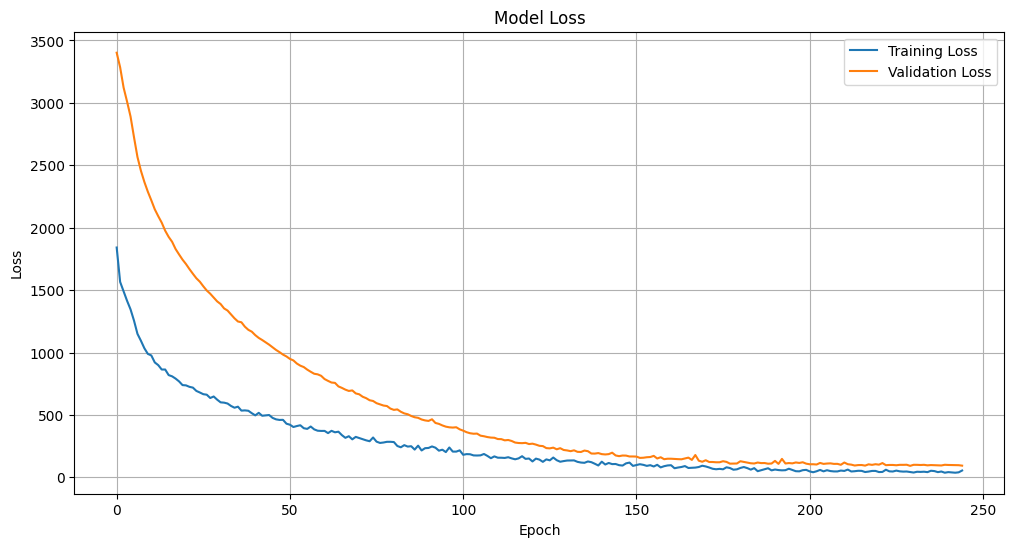

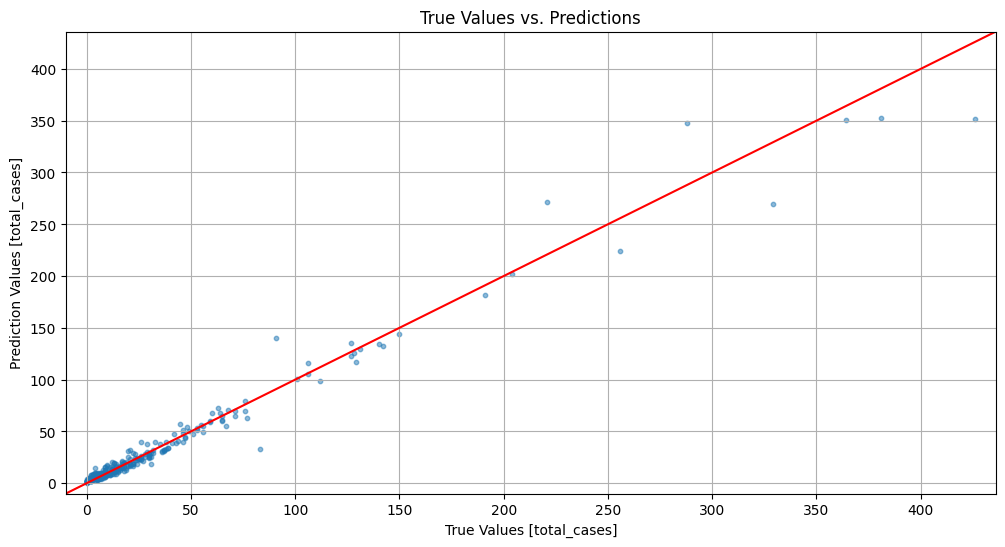

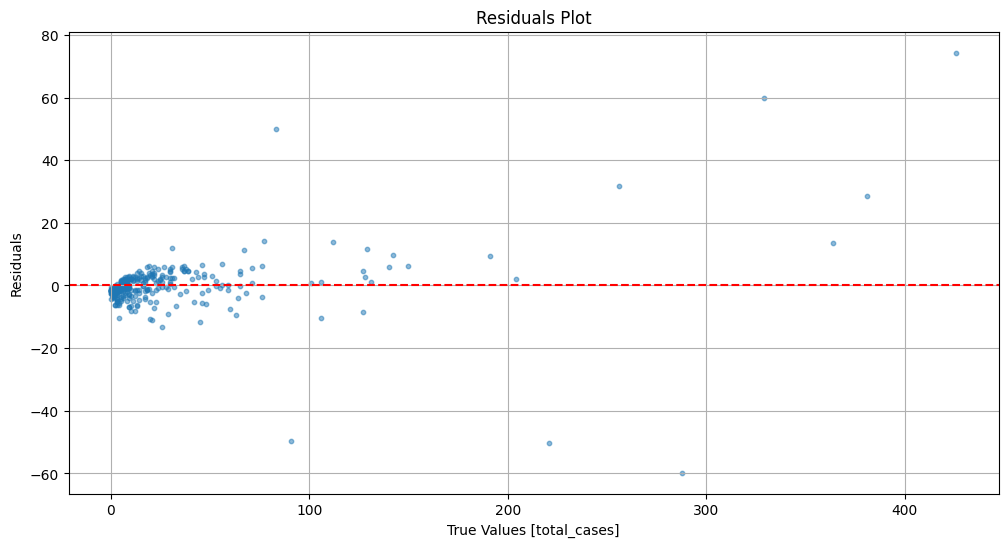

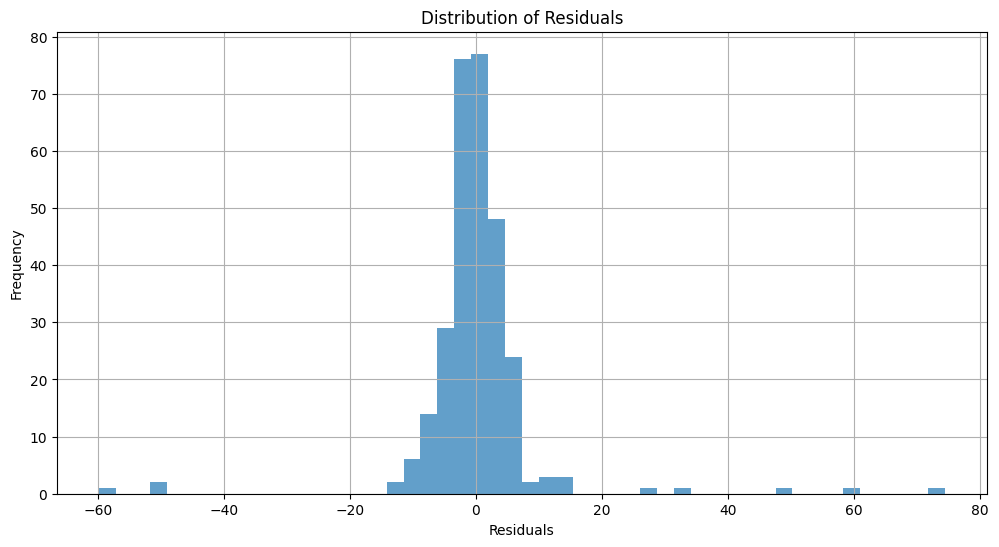

In [2]:
!pip install keras-tuner --quiet
#used: Bi-directional LSTM (Received from S)
#used: Hyper Parameter Tuning: Bayesian Optimization
import os
import logging
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from datetime import datetime
from keras_tuner import BayesianOptimization

import warnings
# Suppress all warnings
from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings('ignore')

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Load and preprocess data
df = pd.read_csv('/content/drive/My Drive/chrf/dengue_features_train_with_out.csv')

# Convert week_start_date to datetime and extract features
df['week_start_date'] = pd.to_datetime(df['week_start_date'])
df['month'] = df['week_start_date'].dt.month
df['day'] = df['week_start_date'].dt.day

# Create lag features for total_cases
for lag in range(1, 6):
    df[f'total_cases_lag{lag}'] = df['total_cases'].shift(lag)

# Create lag features for selected relevant columns
selected_features = ['reanalysis_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_tdtr_k', 'station_diur_temp_rng_c']
for feature in selected_features:
    for lag in range(1, 6):
        df[f'{feature}_lag{lag}'] = df[feature].shift(lag)

df['rolling_mean'] = df['total_cases'].rolling(window=3).mean()
df['rolling_std'] = df['total_cases'].rolling(window=3).std()

# Print the shape before filling NaN values
print("Shape before filling NaN values:", df.shape)

# Fill NaN values using forward fill and backward fill
df.bfill(inplace=True)
df.ffill(inplace=True)

# Print the shape after filling NaN values
print("Shape after filling NaN values:", df.shape)

# Define features and target variable
features = df.drop(['city', 'year', 'weekofyear', 'week_start_date', 'total_cases'], axis=1)
target = df['total_cases']

# Scale features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

# Print the shape of the training and validation sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

# Reshape features for LSTM model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define the LSTM model dynamically using Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(1, X_train.shape[2])))
    model.add(Bidirectional(LSTM(units=hp.Int('units1', min_value=50, max_value=200, step=50), return_sequences=True)))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', min_value=50, max_value=200, step=50)))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=3,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='dengue_prediction'
)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-6, verbose=1)
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stop, reduce_lr, tensorboard_callback])

# Get the best model hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = build_model(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stop, reduce_lr, tensorboard_callback])

# Validate the model
val_predictions = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)
tolerance = 16.30
within_tolerance = np.abs(y_val - val_predictions.flatten()) <= tolerance
accuracy_within_tolerance = np.mean(within_tolerance) * 100

print("Validation MAE:", val_mae)
print("Validation R-squared:", val_r2)
print(f'Accuracy within ±{tolerance}: {accuracy_within_tolerance:.2f}%')

# Function to add jitter to the data
def add_jitter(arr, noise_level=0.01):
    return arr + np.random.normal(0, noise_level, arr.shape)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot True Values vs. Predictions with transparency and jitter
plt.figure(figsize=(12, 6))
plt.scatter(y_val, val_predictions, alpha=0.5, s=10)  # Increased transparency and reduced marker size
plt.xlabel('True Values [total_cases]')
plt.ylabel('Prediction Values [total_cases]')
plt.title('True Values vs. Predictions')
lims = [min(y_val.min(), val_predictions.min()) - 10, max(y_val.max(), val_predictions.max()) + 10]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, color='red')
plt.grid(True)
plt.show()

# Plot Residuals
residuals = y_val - val_predictions.flatten()
plt.figure(figsize=(12, 6))
plt.scatter(y_val, residuals, alpha=0.5, s=10)  # Increased transparency and reduced marker size
plt.xlabel('True Values [total_cases]')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.axhline(0, color='red', linestyle='dashed')
plt.grid(True)
plt.show()

# Plot Distribution of Residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, alpha=0.7)  # Added transparency to histogram
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()
